## Polecenie (ang. Command)

**Typ**: behawioralny  
**Zakres**: obiektowy  
**Inne nazwy**: Akcja (*ang. Action*), Transakcja (*ang. Transakcja*)

<div style="border: solid 1px;padding: 20px;text-align: center">
    Wzorzec <b>polecenie</b> kapsułkuje żądanie w formie obiektu. Umożliwia to parametryzację klienta przy użyciu różnych żądań oraz umieszczanie żadań w kolejkach i dziennikach, a także zapewnia obsłguę cofania operacji.
</div>

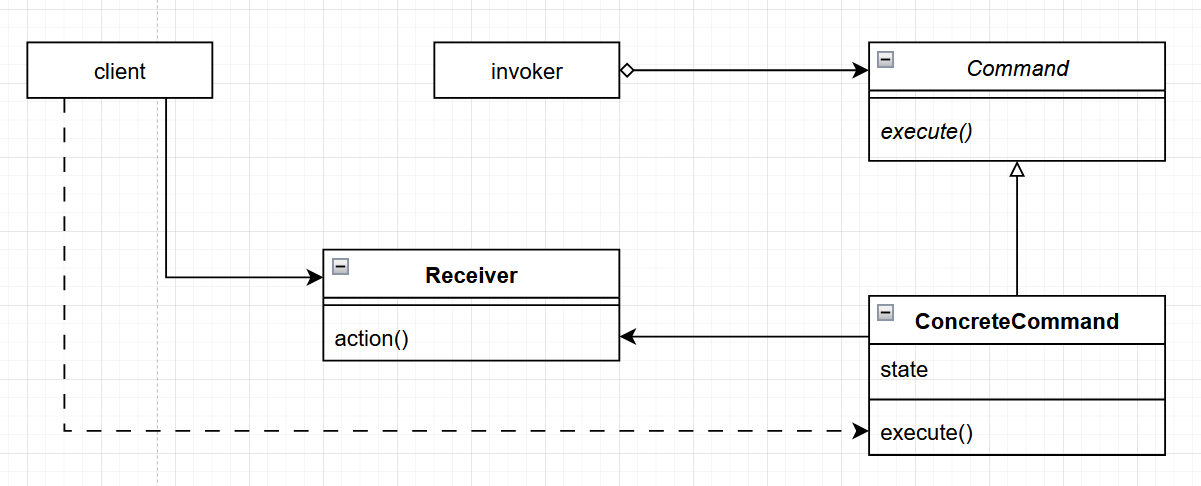

### Problem - sztywne powiązanie akcji z przyciskami

Masz pilota do TV z przyciskami:
- **ON** - włącz TV
- **OFF** - wyłącz TV
- **VOL+** - zwiększ głośność

**Problem:** Jak zaprojektować przyciski żeby:
- Można było łatwo zmienić co robi przycisk
- Cofnąć ostatnią operację (undo)
- Zapisać historię akcji

### Naiwne podejście - bezpośrednie wywołania

In [ ]:
class TV:
    def __init__(self):
        self.is_on = False
        self.volume = 10
    
    def turn_on(self):
        self.is_on = True
        print("📺 TV włączony")
    
    def turn_off(self):
        self.is_on = False
        print("📺 TV wyłączony")
    
    def volume_up(self):
        self.volume += 1
        print(f"🔊 Głośność: {self.volume}")


class RemoteControl:
    def __init__(self, tv):
        self.tv = tv
    
    def on_button(self):
        # ❌ Sztywne powiązanie - pilot "wie" co robi przycisk
        self.tv.turn_on()
    
    def off_button(self):
        self.tv.turn_off()
    
    def volume_up_button(self):
        self.tv.volume_up()

In [ ]:
tv = TV()
remote = RemoteControl(tv)

remote.on_button()
remote.volume_up_button()
remote.off_button()

**Problemy:**
- ❌ **Sztywne powiązanie** - pilot wie co robi każdy przycisk
- ❌ **Nie można zmienić** akcji przycisku bez zmiany pilota
- ❌ **Brak undo** - jak cofnąć `turn_on()`?
- ❌ **Brak historii** - jak zapisać co zostało wykonane?
- ❌ **Brak kolejkowania** - nie możesz zaplanować operacji na później

### Rozwiązanie - wzorzec Polecenie

**Idea:** Akcję **enkapsuluj jako obiekt**. Przycisk nie wie co robi - tylko **wywołuje polecenie**.

### Krok 1: Interfejs Command

In [ ]:
from abc import ABC, abstractmethod

class Command(ABC):
    """Interfejs dla wszystkich poleceń"""
    
    @abstractmethod
    def execute(self):
        """Wykonaj polecenie"""
        pass
    
    @abstractmethod
    def undo(self):
        """Cofnij polecenie"""
        pass

### Krok 2: Receiver (TV) - wie JAK wykonać operację

In [ ]:
# tu bez zmian
class TV:
    """Receiver - wie jak wykonać operacje"""
    
    def __init__(self):
        self.is_on = False
        self.volume = 10
    
    def turn_on(self):
        self.is_on = True
        print("📺 TV włączony")
    
    def turn_off(self):
        self.is_on = False
        print("📺 TV wyłączony")
    
    def volume_up(self):
        self.volume += 1
        print(f"🔊 Głośność: {self.volume}")
    
    def volume_down(self):
        self.volume -= 1
        print(f"🔉 Głośność: {self.volume}")

### Krok 3: Konkretne polecenia

In [ ]:
class TurnOnCommand(Command):
    """Polecenie: Włącz TV"""
    
    def __init__(self, tv: TV):
        self.tv = tv
    
    def execute(self):
        self.tv.turn_on()
    
    def undo(self):
        self.tv.turn_off()  # Cofnięcie = wyłącz


class TurnOffCommand(Command):
    """Polecenie: Wyłącz TV"""
    
    def __init__(self, tv: TV):
        self.tv = tv
    
    def execute(self):
        self.tv.turn_off()
    
    def undo(self):
        self.tv.turn_on()  # Cofnięcie = włącz


class VolumeUpCommand(Command):
    """Polecenie: Zwiększ głośność"""
    
    def __init__(self, tv: TV):
        self.tv = tv
    
    def execute(self):
        self.tv.volume_up()
    
    def undo(self):
        self.tv.volume_down()  # Cofnięcie = zmniejsz

**Kluczowa zmiana:**
- Polecenie **enkapsuluje** akcję (`tv.turn_on()`) jako obiekt
- Polecenie **wie** jak się cofnąć (`undo()`)
- Polecenie **przechowuje referencję** do receiver/odbiorcy (`self.tv`)

### Krok 4: Invoker (pilot) - wywołuje polecenia

In [ ]:
class RemoteControl:
    """Invoker - przechowuje i wywołuje polecenia"""
    
    def __init__(self):
        self.command = None  # Aktualnie przypisane polecenie
        self.history = []    # Historia wykonanych poleceń
    
    def set_command(self, command: Command):
        """Przypisz polecenie do przycisku"""
        self.command = command
    
    def press_button(self):
        """Naciśnij przycisk - wykonaj polecenie"""
        if self.command:
            self.command.execute()
            self.history.append(self.command)  # Zapisz w historii
    
    def press_undo(self):
        """Cofnij ostatnie polecenie"""
        if self.history:
            last_command = self.history.pop()
            last_command.undo()
        else:
            print("❌ Brak poleceń do cofnięcia")

**Invoker:**
- **Nie wie** co robi polecenie
- Tylko wywołuje `command.execute()`
- Przechowuje **historię** poleceń

### Krok 5: Użycie - elastyczne przypisywanie

In [ ]:
# Tworzenie obiektów
tv = TV()
remote = RemoteControl()

# Tworzenie poleceń
turn_on = TurnOnCommand(tv)
turn_off = TurnOffCommand(tv)
volume_up = VolumeUpCommand(tv)

# Przypisanie polecenia do przycisku
remote.set_command(turn_on)
remote.press_button()  # Włącz TV

# Zmiana polecenia
remote.set_command(volume_up)
remote.press_button()  # Zwiększ głośność
remote.press_button()  # Zwiększ głośność

# Undo
print("\n=== UNDO ===")
remote.press_undo()  # Cofnij volume_up
remote.press_undo()  # Cofnij volume_up
remote.press_undo()  # Cofnij turn_on

**Zalety:**
- ✅ **Luźne powiązanie** - pilot nie wie co robi polecenie
- ✅ **Elastyczność** - `set_command()` zmienia akcję przycisku
- ✅ **Undo/Redo** - polecenia wiedzą jak się cofnąć
- ✅ **Historia** - możesz śledzić co zostało wykonane
- ✅ **Kolejkowanie** - możesz zaplanować polecenia

## Jak to działa?

**Invoker (remote) → Command (turn_on) → Receiver (tv)**

## Struktura wzorca

**Elementy wzorca Polecenie:**

1. **Command** - `Command`
   - Interfejs dla wszystkich poleceń
   - Metody: `execute()`, `undo()`

2. **ConcreteCommand** - `TurnOnCommand`, `VolumeUpCommand`
   - Konkretne polecenie
   - Przechowuje referencję do **Receiver**
   - Implementuje `execute()` - deleguje do receiver
   - Implementuje `undo()` - odwraca operację

3. **Receiver** - `TV`
   - Wie **jak** wykonać operację
   - Zawiera logikę biznesową

4. **Invoker** - `RemoteControl`
   - Przechowuje polecenia
   - Wywołuje `command.execute()`
   - **Nie wie** co robi polecenie

5. **Client**
   - Tworzy polecenia
   - Przypisuje polecenia do invokera

**Kluczowa właściwość:**
> Polecenie **enkapsuluje** żądanie jako obiekt - Invoker nie wie CO wykona

## Przykład 2 - Edytor tekstu z undo/redo

In [ ]:
from abc import ABC, abstractmethod

# ════════════════════════════════════════════════════════════
# Receiver - Dokument
# ════════════════════════════════════════════════════════════
class Document:
    def __init__(self):
        self.content = ""
    
    def write(self, text: str):
        self.content += text
        print(f"📝 Dokument: '{self.content}'")
    
    def delete(self, length: int):
        self.content = self.content[:-length]  # usuń ostatnie length znaków
        print(f"📝 Dokument: '{self.content}'")


# ════════════════════════════════════════════════════════════
# Command
# ════════════════════════════════════════════════════════════
class Command(ABC):
    @abstractmethod
    def execute(self):
        pass
    
    @abstractmethod
    def undo(self):
        pass


# ════════════════════════════════════════════════════════════
# ConcreteCommand
# ════════════════════════════════════════════════════════════
class WriteCommand(Command):
    def __init__(self, document: Document, text: str):
        self.document = document
        self.text = text
    
    def execute(self):
        self.document.write(self.text)
    
    def undo(self):
        # Cofnij przez usunięcie tego co dodaliśmy
        self.document.delete(len(self.text))


# ════════════════════════════════════════════════════════════
# Invoker - Edytor
# ════════════════════════════════════════════════════════════
class Editor:
    def __init__(self):
        self.history = []    # Stos undo
        self.redo_stack = []  # Stos redo
    
    def execute_command(self, command: Command):
        command.execute()
        self.history.append(command)
        self.redo_stack.clear()  # Czyścimy redo po nowej operacji
    
    def undo(self):
        if self.history:
            command = self.history.pop()
            command.undo()
            self.redo_stack.append(command)  # Przenosimy do redo
        else:
            print("❌ Brak operacji do cofnięcia")
    
    def redo(self):
        if self.redo_stack:
            command = self.redo_stack.pop()
            command.execute()
            self.history.append(command)  # Przenosimy z powrotem
        else:
            print("❌ Brak operacji do powtórzenia")

In [ ]:
# Tworzenie
doc = Document()
editor = Editor()

# Pisanie
editor.execute_command(WriteCommand(doc, "Hello"))
editor.execute_command(WriteCommand(doc, " World"))
editor.execute_command(WriteCommand(doc, "!"))

# Undo
print("\n=== UNDO ===")
editor.undo()  # Usuwa "!"
editor.undo()  # Usuwa " World"

# Redo
print("\n=== REDO ===")
editor.redo()  # Przywraca " World"
editor.redo()  # Przywraca "!"

**Undo/Redo:**
- `history` - stos wykonanych poleceń (undo)
- `redo_stack` - stos cofniętych poleceń (redo)
- Undo: `pop()` z history → `undo()` → `push()` do redo
- Redo: `pop()` z redo → `execute()` → `push()` do history

## Makro - złożone polecenia

In [ ]:
class MacroCommand(Command):
    """Złożone polecenie - wykonuje wiele poleceń"""
    
    def __init__(self, commands: list):
        self.commands = commands
    
    def execute(self):
        print("🎬 Wykonuję makro:")
        for command in self.commands:
            command.execute()
    
    def undo(self):
        print("⏪ Cofam makro:")
        # Cofaj w odwrotnej kolejności!
        for command in reversed(self.commands):
            command.undo()

In [ ]:
tv = TV()
remote = RemoteControl()

# Makro: Włącz TV + zwiększ głośność 3x
party_mode = MacroCommand([
    TurnOnCommand(tv),
    VolumeUpCommand(tv),
    VolumeUpCommand(tv),
    VolumeUpCommand(tv),
])

remote.set_command(party_mode)
remote.press_button()  # Wykonuje wszystkie 4 polecenia

print("\n=== UNDO MAKRO ===")
remote.press_undo()  # Cofa wszystkie 4 polecenia

## Kiedy używać wzorca Polecenie?

Wzorzec Polecenie stosuj gdy:

1. **Chcesz parametryzować obiekty za pomocą akcji**
   - Przycisk nie wie co robi - dostaje polecenie

2. **Potrzebujesz undo/redo**
   - Polecenia wiedzą jak się cofnąć
   - Historia poleceń

3. **Kolejkowanie operacji**
   - Zaplanuj polecenia na później
   - Thread pool, task queue

4. **Logowanie/Audyt**
   - Zapisz co zostało wykonane
   - Replay operacji

5. **Transakcje**
   - Execute all or rollback all

**Przykłady praktyczne:**
- Edytory tekstu (undo/redo)
- GUI buttons/menu items
- Task schedulers
- Transakcje bazodanowe
- Makra w aplikacjach
- Job queues (Celery, RabbitMQ)

## Polecenie vs Strategia

**Oba enkapsulują operację, ale:**

| Aspekt | Polecenie | Strategia |
|--------|-----------|----------|
| **Cel** | Enkapsulacja **żądania** | Enkapsulacja **algorytmu** |
| **Receiver** | Ma receiver (deleguje do niego) | NIE ma receiver (sam wykonuje) |
| **Undo** | Wspiera undo/redo | NIE wspiera undo |
| **Stan** | Może przechowywać stan | Zwykle bezstanowa |
| **Kolejkowanie** | Tak (historie, makra) | Nie |

**Polecenie:**
```python
command = TurnOnCommand(tv)  # Przechowuje receiver
command.execute()  # Deleguje: tv.turn_on()
command.undo()     # Cofa: tv.turn_off()
```

**Strategia:**
```python
strategy = QuickSort()  # Nie ma receiver
strategy.sort(data)     # Sam sortuje (algorytm)
# Brak undo
```

## Podsumowanie

Wzorzec Polecenie:
- ✅ **Enkapsuluje żądanie** jako obiekt
- ✅ **Luźne powiązanie** - Invoker nie wie co robi polecenie
- ✅ **Undo/Redo** - polecenia wiedzą jak się cofnąć
- ✅ **Historia** - łatwe śledzenie operacji
- ✅ **Kolejkowanie** - planowanie operacji
- ✅ **Makra** - złożone polecenia z wielu prostych
- ⚠️ **Więcej klas** - każda operacja = osobna klasa

**Kluczowa idea:**
> **Żądanie jako obiekt** - Invoker wywołuje `command.execute()`, nie wiedząc CO wykona

**Struktura:**
```python
# Command
class Command(ABC):
    @abstractmethod
    def execute(self):
        pass
    
    @abstractmethod
    def undo(self):
        pass

# ConcreteCommand
class ConcreteCommand(Command):
    def __init__(self, receiver):
        self.receiver = receiver
    
    def execute(self):
        self.receiver.action()  # Delegacja
    
    def undo(self):
        self.receiver.reverse_action()

# Invoker
class Invoker:
    def set_command(self, command):
        self.command = command
    
    def execute(self):
        self.command.execute()
```

**Istota wzorca:**
- **Enkapsulacja:** Żądanie `tv.turn_on()` → obiekt `TurnOnCommand`
- **Delegacja:** Command → Receiver (polecenie wie do kogo delegować)
- **Odwracalność:** `execute()` + `undo()` = para operacji odwracalnych
- **Historia:** Stos poleceń = możliwość undo/redo

**Formuła:**
- **Invoker** (`remote`) - wywołuje polecenia (`command.execute()`)
- **Command** (`TurnOnCommand`) - enkapsuluje żądanie
- **Receiver** (`TV`) - wie JAK wykonać operację (`turn_on()`)
- **Client** - tworzy polecenia i łączy z invokerem